# Summary
* Purpose: Compute resolution functions for SnS CNCS dataset.
* Procedure:
  - Simulate beam
  - Prepare sample
  - Simulate resolution
 

# Tools

In [1]:
pwd

u'/SNS/users/lj7/notebooks/.rk-work/jnrk-sns-analysis-python2-default'

** Modify the workdir !!! **

In [2]:
workdir = "/SNS/users/tysonlanigan/SnS/Resolution"

In [5]:
# workdir = '/SNS/users/lj7/simulations/CNCS/AgBiSe2/Tyson/'

In [6]:
mkdir -p {workdir}

In [6]:
cd {workdir}

/SNS/users/lj7/simulations/CNCS/AgBiSe2/Tyson


In [7]:
# %matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np, os, glob
import histogram.hdf as hh, histogram as H

In [8]:
!which mcvine

/SNS/software/miniconda2/envs/py2/bin/mcvine


In [9]:
from dgsres.singlextal import use_res_comps

In [11]:
# use_res_comps

# Beam

** NOTE: You can skip this section if there is existing beam simulation that you can reuse. Just make a symbolic link **

JLN - Did not rerun the simulation, but copied files from lj7 to local directory to avoid clobbering his simulations and to maintain my own copy for future reference.

In [12]:
mkdir -p beam_17meV

In [13]:
cd {workdir}/beam_17meV/

/SNS/users/lj7/simulations/CNCS/AgBiSe2/Tyson/beam_17meV


** Options for the beam simulation **

In [14]:
!mcvine instruments cncs beam --help-properties

properties of 'cncs_beam':
    E=<float>: desired incident beam energy. unit: meV
        default value: 20
        current value: 20.0, from {default}
    dumpconfiguration=<bool>: If set, dump configuration to a pml file
        default value: 0
        current value: False, from {default}
    dumpconfiguration-output=<str>: Output file path of dumped configuration file (pml)
        default value: ''
        current value: '', from {default}
    f1=<float>: Chopper freq 1. unit: Hz
        default value: 60
        current value: 60.0, from {default}
    f2=<float>: Chopper freq 2. unit: Hz
        default value: 60
        current value: 60.0, from {default}
    f3=<float>: Chopper freq 3. unit: Hz
        default value: 60
        current value: 60.0, from {default}
    f41=<float>: Chopper freq 41. unit: Hz
        default value: 300
        current value: 300.0, from {default}
    f42=<float>: Chopper freq 42. unit: Hz
        default value: 300
        current value: 300.0, fro

Notes about fluxmode:

      High Flux (HF)    = 9.0 deg
      Intermidiste (AI) = 4.4 deg
      High Res (HR)     = 2.0 deg


In [16]:
%%time
!mcvine instruments cncs beam -E=17 -f1=60 -f2=60 -f3=60 -f41=240 -f42=240 -ncount=1e9 -fluxmode=4.4 -nodes=20 >log.sim

/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/mcni/AbstractComponent.py:40: UserWarning: In NeutronToStorage: Deprecated. should use self.simulation_context.overwrite_datafiles
  warnings.warn(msg)
/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/mcni/AbstractComponent.py:40: UserWarning: In NeutronToStorage: Deprecated. should use self.simulation_context.overwrite_datafiles
  warnings.warn(msg)
/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/mcni/AbstractComponent.py:40: UserWarning: In NeutronToStorage: Deprecated. should use self.simulation_context.overwrite_datafiles
  warnings.warn(msg)
/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/mcni/AbstractComponent.py:40: UserWarning: In NeutronToStorage: Deprecated. should use self.simulation_context.overwrite_datafiles
  warnings.warn(msg)
/SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/mcni/AbstractComponent.py:40: UserWarning: In NeutronToStorage: Deprecated. should

In [17]:
pwd

u'/SNS/users/lj7/simulations/CNCS/AgBiSe2/Tyson/beam_17meV'

In [18]:
ls

cncs_moderator2sample.pml
log.sim
_m2sout/
mcvine-instruments-cncs-beam.params
mcvine-instruments-cncs-config_mod2sample.params
mcvine-instruments-cncs-mod2sample.params
out/
run-m2s.sh


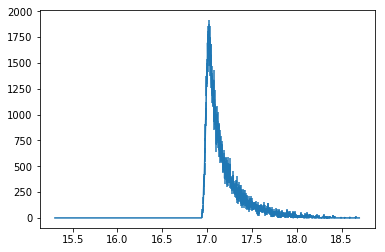

In [20]:
H.plot(hh.load('out/ienergy.h5'))

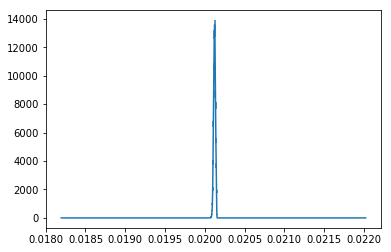

In [21]:
H.plot(hh.load('out/itof.h5')[(0.0181976262492,0.0220193209713)])

In [22]:
ls out

ienergy.h5  ix_divx.h5  ix_y.h5     iy_divy.h5  props.json
itof.h5     ix_divy.h5  iy_divx.h5  neutrons    rank0-step0/


In [23]:
cat out/props.json

{'emission time': '119.031323571 microsecond', 'flux': '102697.291492 counts per 34kJ pulse', 'tof fwhm': '24.1301683326 microsecond', 'average tof': '20121.6783567 microsecond', 'average energy': '17.1803572162 meV'}

In [25]:
#This is the total number of neutrons on the sample.  Typically Jiao recommends this number be greater than 1e6.

!mcvine neutronstorage count out/neutrons

22917


# Sample

In [26]:
cd {workdir}

/SNS/users/lj7/simulations/CNCS/AgBiSe2/Tyson


In [27]:
%%file sample.yaml
name: SnS
chemical_formula: SnS
lattice: 
 constants: 11.2, 3.987, 4.334, 90, 90, 90
 basis_vectors:
  - 11.2, 0, 0
  - 0, 3.987, 0
  - 0, 0, 4.334
excitations:
 - type: DGSresolution
orientation:
 u: 1, 0, 0
 v: 0, 0, 1
shape: cylinder radius="1*cm" height="2*cm"
temperature: 300*K

Writing sample.yaml


In [28]:
sampleyml = "{workdir}/sample.yaml".format(**locals())

In [29]:
print sampleyml

/SNS/users/lj7/simulations/CNCS/AgBiSe2/Tyson//sample.yaml


# CNCS Instrument

In [44]:
#Here define the angle ranges for the sample scattering and instrument properties
beam = os.path.join(workdir, 'beam_17meV')
print "Using beam at", beam
psi_axis = -30, 60, 1
instrument = use_res_comps.instrument(
    name = 'CNCS',
    detsys_radius = "3.5*meter",
    L_m2s = "36.264*meter",
    offset_sample2beam = "-0.15*meter" # offset from sample to saved beam
    )
pixel = use_res_comps.pixel(
    radius = "0.5*inch",
    height = "2.*meter/128",
    pressure = "6*atm",
    )

Using beam at /SNS/users/lj7/simulations/CNCS/AgBiSe2/Tyson/beam_17meV


## psi scan

In [32]:
class psi_scan:
    min = -30.
    max = 60.
    step = 1.

# Try one point

In [33]:
cd {workdir}

/SNS/users/lj7/simulations/CNCS/AgBiSe2/Tyson


** Define projection direction and starting point **

In [34]:
hkl_projection = np.array([0,0,1])

In [53]:
hkl0 = np.array([0.,0,0])
hkl0

array([ 0.,  0.,  0.])

** Plot dynamical range **

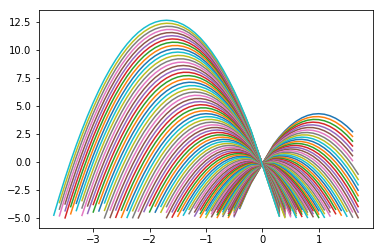

In [54]:
from mcvine.workflow.singlextal import dynrange
from mcvine.workflow.sample import loadSampleYml
sample = loadSampleYml(os.path.join(workdir, 'sample.yaml'))
psilist = np.arange(psi_scan.min, psi_scan.max, psi_scan.step)
Ei = 17.1803572162
xaxis = np.arange(-6, 6, .1)
def scattering_angle_constraints(theta, phi):
    return ((theta<135.) * (theta > 3.) + (theta < -3)*(theta>-50)) * (phi<16) * (phi>-16)

plt.figure()

dynrange.plotDynRangeOfSlice(
    sample, psilist, Ei, hkl0, hkl_projection, xaxis,
    scattering_angle_constraints,
    Erange=(-5, 16))
plt.show()

** Define point of interest **

In [55]:
E = 5.
x = -2

In [56]:
hkl = hkl0 + hkl_projection*x

In [57]:
hkl

array([ 0.,  0., -2.])

** Run simulation setup **

In [58]:
pwd

u'/SNS/users/lj7/simulations/CNCS/AgBiSe2/Tyson'

In [59]:
rm -rf test/

In [60]:
use_res_comps.setup(
    'test',
    sampleyml, beam, E, hkl, hkl_projection,
    psi_scan, instrument, pixel)

Ei=17.1803572162, t0=119.031323548
Computed:
* psi=40.3901876575 degree
* Q=[ 1.87883615 -2.20839116  0.        ]
* hkl2Qmat=[[ 0.42728425  0.36352124  0.        ]
 [-0.         -0.         -1.57591806]
 [-0.93941807  1.10419558  0.        ]]
* ki=2.87944276204
* vectors ki=[ 2.87944276  0.          0.        ], kf=[ 1.00060661  2.20839116  0.        ]
These two numbers should be very close:
  5.0
  5.0
  Ei=17.1803572162, Ef=12.1803572162
* Ef=12.1803572162
* pixel positon=[ 1.44447173  3.18802469  0.        ]
* pixel_position=[ 1.44447173  3.18802469  0.        ]
t_m2s=0.0201216783567, t_s2p=0.00229279851586, t_m2p=0.0224144768726


In [61]:
ls test

run.py  sample/


In [62]:
#! cat test/run.py

In [63]:
#! cat test/sample/AgBiSe2-scatterer.xml

** Run simulation. This will take a couple minutes **

In [64]:
!cd test && python run.py

weight:  1.0
0-9999: ........../SNS/software/miniconda2/envs/py2/lib/python2.7/site-packages/mcni/SimulationContext.py:39: UserWarning: output directory was not set
  warnings.warn("output directory was not set")

10000-19999: ..........
20000-22916: ..........
Done.


In [65]:
# !cat test/log.run

In [66]:
ls -tl test

total 610
-rw-r--r-- 1 lj7 users  23952 Feb  6 14:25 res.h5
-rw-r--r-- 1 lj7 users 151136 Feb  6 14:25 probs.npy
-rw-r--r-- 1 lj7 users 151136 Feb  6 14:25 dEs.npy
-rw-r--r-- 1 lj7 users 151136 Feb  6 14:25 dxs.npy
-rw-r--r-- 1 lj7 users 453248 Feb  6 14:25 dhkls.npy
-rw-r--r-- 1 lj7 users   1193 Feb  6 14:25 run.py
drwxr-xr-x 2 lj7 users      5 Feb  6 14:25 sample/


In [67]:
pwd

u'/SNS/users/lj7/simulations/CNCS/AgBiSe2/Tyson'

plot z in (0.0, 0.0653912609786)


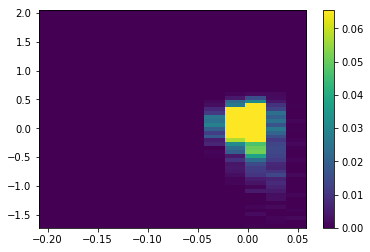

In [70]:
H.plot(hh.load("test/res.h5")[(-0.2,None), (None, 2)])

In [71]:
pwd

u'/SNS/users/lj7/simulations/CNCS/AgBiSe2/Tyson'

In [72]:
ls test

dEs.npy  dhkls.npy  dxs.npy  probs.npy  res.h5  run.py  sample/


In [31]:
# load simulated data
probs = np.load('test/probs.npy')
dEs = np.load('test/dEs.npy')
dhkls = np.load('test/dhkls.npy')

In [33]:
# compute 2D histogram with q and E axes
qs = np.dot(dhkls, hkl_projection)/np.linalg.norm(hkl_projection)**2
I, qedges, Eedges = np.histogram2d(bins=(np.arange(-0.2, 0.2, 0.005), np.arange(-2,2,0.1)), weights=probs, x=qs, y=dEs )

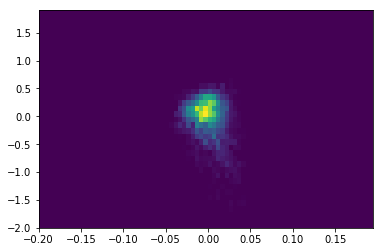

In [34]:
# plot
Xg, Eg = np.meshgrid(xedges, Eedges)
plt.pcolormesh(Xg, Eg, I.T)

In [510]:
#dEs.npy is the energy, dhkls is the hkl value, dxs is the offset from the origin, 

In [73]:
resVals = hh.load('test/res.h5')


In [76]:
res = hh.load('test/res.h5')
intensity = res.I
qvals = res.x
energies = res.E
 
import numpy as np
np.savetxt('intensity.txt',intensity)
np.savetxt('qvals.txt',qvals)
np.savetxt('energies.txt',energies)

In [78]:
np.loadtxt('intensity.txt')

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   2.32136017e+09],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  2.85640242e-04,   0.00000000e+00,   3.93271277e-11, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   6.50651116e-04,   1.24617665e-03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.67525916e-03, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [80]:
np.loadtxt('qvals.txt')

array([-1.9897071 , -1.96912131, -1.94853551, -1.92794971, -1.90736391,
       -1.88677811, -1.86619231, -1.84560651, -1.82502071, -1.80443491,
       -1.78384912, -1.76326332, -1.74267752, -1.72209172, -1.70150592,
       -1.68092012, -1.66033432, -1.63974852, -1.61916272, -1.59857692,
       -1.57799113, -1.55740533, -1.53681953, -1.51623373, -1.49564793,
       -1.47506213, -1.45447633, -1.43389053, -1.41330473, -1.39271893,
       -1.37213314, -1.35154734, -1.33096154, -1.31037574, -1.28978994,
       -1.26920414, -1.24861834, -1.22803254, -1.20744674, -1.18686095,
       -1.16627515, -1.14568935, -1.12510355, -1.10451775, -1.08393195,
       -1.06334615, -1.04276035, -1.02217455, -1.00158875, -0.98100296,
       -0.96041716, -0.93983136, -0.91924556, -0.89865976, -0.87807396,
       -0.85748816, -0.83690236, -0.81631656, -0.79573076, -0.77514497,
       -0.75455917, -0.73397337, -0.71338757, -0.69280177, -0.67221597,
       -0.65163017, -0.63104437, -0.61045857, -0.58987277, -0.56

In [81]:
np.loadtxt('energies.txt')

array([-1.68964704, -1.62241441, -1.55518178, -1.48794914, -1.42071651,
       -1.35348388, -1.28625124, -1.21901861, -1.15178598, -1.08455334,
       -1.01732071, -0.95008807, -0.88285544, -0.81562281, -0.74839017,
       -0.68115754, -0.61392491, -0.54669227, -0.47945964, -0.41222701,
       -0.34499437, -0.27776174, -0.2105291 , -0.14329647, -0.07606384,
       -0.0088312 ,  0.05840143,  0.12563406,  0.1928667 ,  0.26009933,
        0.32733196,  0.3945646 ,  0.46179723,  0.52902987,  0.5962625 ,
        0.66349513,  0.73072777,  0.7979604 ,  0.86519303,  0.93242567,
        0.9996583 ,  1.06689093,  1.13412357,  1.2013562 ,  1.26858883,
        1.33582147,  1.4030541 ,  1.47028674,  1.53751937,  1.604752  ,
        1.67198464,  1.73921727,  1.8064499 ,  1.87368254,  1.94091517,
        2.0081478 ,  2.07538044,  2.14261307,  2.20984571,  2.27707834,
        2.34431097,  2.41154361,  2.47877624,  2.54600887,  2.61324151,
        2.68047414,  2.74770677,  2.81493941,  2.88217204,  2.94

# NOW Trying to run the calculation along a given direction for the fitted energy and Q centroids

In [265]:
cd {workdir}

/SNS/users/3qn/AgBiSe2/Resolution


In [15]:
hkl_projection = np.array([0,0,1])

In [267]:
hkl0 = np.array([-2,-2,0])
hkl0

array([-2, -2,  0])

** Define point of interest **

In [333]:
#E = 2.87
#x = 0.3
tag = 'm2m2mL'

Evals = [2.868,3.3942,3.7917,4.1122,4.4037,4.5681,4.6188,4.7303]
Lvals = [-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,-1.0]


In [376]:
run = 7
E = Evals[run]
x = Lvals[run]

In [377]:
hkl = hkl0 + hkl_projection*x

In [378]:
hkl

array([-2., -2., -1.])

** Run simulation setup **

In [379]:
use_res_comps.setup(
    '{0}_{1}'.format(tag,x),
    sampleyml, beam, E, hkl, hkl_projection,
    psi_axis, instrument, pixel)

15.1557796266 125.075700477
Ei=15.1557796266, t0=125.075700477
Computed:
* psi=66.1808076703 degree
* Q=[  2.35138923e+00  -2.21509440e+00  -5.46835878e-17]
* hkl2Qmat=[[ -6.96565193e-01   3.07500614e-01  -7.61419527e-01]
 [ -6.96565193e-01   3.07500614e-01   7.61419527e-01]
 [  4.34871538e-01   9.85091943e-01   5.46835878e-17]]
* ki=2.70446581426
* vectors ki=[ 2.70446581  0.          0.        ], kf=[  3.53076581e-01   2.21509440e+00   5.46835878e-17]
These two numbers should be very close:
4.7303
4.7303
  Ei=15.1557796266, Ef=10.4254796266
* Ef=10.4254796266
* pixel positon=[  5.50930200e-01   3.45636745e+00   8.53266447e-17]
* pixel_position=[  5.50930200e-01   3.45636745e+00   8.53266447e-17]
t_m2s=0.0214218792754, t_s2p=0.00247826579355, t_m2p=0.023900145069


In [380]:
pwd

u'/SNS/users/3qn/AgBiSe2/Resolution'

** Run simulation. This will take a couple minutes **

In [381]:
!cd m2m2mL_-1.0 && python run.py

weight:  1.0
0-99999: ........../SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mcni/SimulationContext.py:39: UserWarning: output directory was not set
  warnings.warn("output directory was not set")

100000-199999: ..........
200000-299999: ..........
300000-399999: ..........
400000-499999: ..........
500000-599999: ..........
Done.


plot z in (0.0, 1.33698126626)


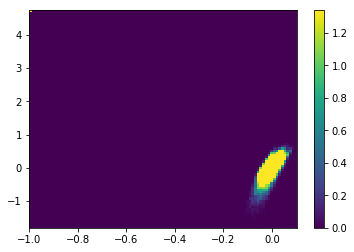

In [382]:
H.plot(hh.load("{0}_{1}/res.h5".format(tag,x)))

In [383]:
##now try extracting the intensities for overplotting

In [384]:
cd {workdir}

/SNS/users/3qn/AgBiSe2/Resolution


In [385]:
res = hh.load("{0}_{1}/res.h5".format(tag,x))
I = res.I
resx = res.x
resE = res.E

In [386]:
print I.max()

142097189162.0


In [387]:
print resx

[-0.99448436 -0.98345307 -0.97242178 -0.96139049 -0.95035921 -0.93932792
 -0.92829663 -0.91726534 -0.90623405 -0.89520276 -0.88417148 -0.87314019
 -0.8621089  -0.85107761 -0.84004632 -0.82901504 -0.81798375 -0.80695246
 -0.79592117 -0.78488988 -0.7738586  -0.76282731 -0.75179602 -0.74076473
 -0.72973344 -0.71870215 -0.70767087 -0.69663958 -0.68560829 -0.674577
 -0.66354571 -0.65251443 -0.64148314 -0.63045185 -0.61942056 -0.60838927
 -0.59735798 -0.5863267  -0.57529541 -0.56426412 -0.55323283 -0.54220154
 -0.53117026 -0.52013897 -0.50910768 -0.49807639 -0.4870451  -0.47601381
 -0.46498253 -0.45395124 -0.44291995 -0.43188866 -0.42085737 -0.40982609
 -0.3987948  -0.38776351 -0.37673222 -0.36570093 -0.35466965 -0.34363836
 -0.33260707 -0.32157578 -0.31054449 -0.2995132  -0.28848192 -0.27745063
 -0.26641934 -0.25538805 -0.24435676 -0.23332548 -0.22229419 -0.2112629
 -0.20023161 -0.18920032 -0.17816903 -0.16713775 -0.15610646 -0.14507517
 -0.13404388 -0.12301259 -0.11198131 -0.10095002 -0.08

In [388]:
print resE

[-1.77075481 -1.70541758 -1.64008034 -1.57474311 -1.50940587 -1.44406864
 -1.37873141 -1.31339417 -1.24805694 -1.1827197  -1.11738247 -1.05204523
 -0.986708   -0.92137077 -0.85603353 -0.7906963  -0.72535906 -0.66002183
 -0.59468459 -0.52934736 -0.46401013 -0.39867289 -0.33333566 -0.26799842
 -0.20266119 -0.13732395 -0.07198672 -0.00664949  0.05868775  0.12402498
  0.18936222  0.25469945  0.32003669  0.38537392  0.45071115  0.51604839
  0.58138562  0.64672286  0.71206009  0.77739733  0.84273456  0.90807179
  0.97340903  1.03874626  1.1040835   1.16942073  1.23475797  1.3000952
  1.36543243  1.43076967  1.4961069   1.56144414  1.62678137  1.69211861
  1.75745584  1.82279307  1.88813031  1.95346754  2.01880478  2.08414201
  2.14947925  2.21481648  2.28015371  2.34549095  2.41082818  2.47616542
  2.54150265  2.60683989  2.67217712  2.73751435  2.80285159  2.86818882
  2.93352606  2.99886329  3.06420053  3.12953776  3.19487499  3.26021223
  3.32554946  3.3908867   3.45622393  3.52156117  3.

In [389]:
import numpy as np
np.save("{2}_{0}/resE_{0}_{1}".format(x,E,tag),resE)
np.save("{2}_{0}/resX_{0}_{1}".format(x,E,tag),resx)
np.save("{2}_{0}/res_{0}_{1}".format(x,E,tag),I)